In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.cluster import KMeans
import plotly.express as px

# Cargar archivo CSV
df = pd.read_csv('online_retail.csv', encoding='ISO-8859-1')
df.head()


,ï»¿InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/10 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/10 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/10 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/10 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/10 8:26,3.39,17850.0,United Kingdom


In [2]:
# Eliminar filas con valores nulos
df.dropna(inplace=True)

# Eliminar transacciones con devoluciones (Invoice que empieza con "C")
df = df[~df['ï»¿InvoiceNo'].astype(str).str.startswith('C')]

# Eliminar duplicados
df.drop_duplicates(inplace=True)

# Convertir la columna de fecha
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Crear columna de ingreso total por línea
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Verificar
df.info()

<ipython-input-2-82433633>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(inplace=True)
<ipython-input-2-82433633>:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])


<class 'pandas.core.frame.DataFrame'>
Index: 166746 entries, 0 to 240006
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   ï»¿InvoiceNo  166746 non-null  object        
 1   StockCode     166746 non-null  object        
 2   Description   166746 non-null  object        
 3   Quantity      166746 non-null  int64         
 4   InvoiceDate   166746 non-null  datetime64[ns]
 5   UnitPrice     166746 non-null  float64       
 6   CustomerID    166746 non-null  float64       
 7   Country       166746 non-null  object        
 8   TotalPrice    166746 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 12.7+ MB


In [3]:
# Fecha de referencia para calcular "Recency"
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

# Agrupar por cliente
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'ï»¿InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
})

# Renombrar columnas
rfm.columns = ['Recency', 'Frequency', 'Monetary']
rfm = rfm[rfm['Monetary'] > 0]  # Eliminar clientes con gasto 0

rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,160,1,77183.60
12347.0,17,4,2205.95
12348.0,83,3,1487.24
12350.0,144,1,334.40
12352.0,96,5,1561.81


In [4]:
# Cuartiles seguros con rank transform
rfm['R_quartile'] = pd.qcut(rfm['Recency'].rank(method='first'), 4, labels=[4, 3, 2, 1])
rfm['F_quartile'] = pd.qcut(rfm['Frequency'].rank(method='first'), 4, labels=[1, 2, 3, 4])
rfm['M_quartile'] = pd.qcut(rfm['Monetary'].rank(method='first'), 4, labels=[1, 2, 3, 4])


# Concatenar para crear segmento RFM
rfm['RFM_Score'] = rfm['R_quartile'].astype(str) + rfm['F_quartile'].astype(str) + rfm['M_quartile'].astype(str)

rfm.head()


,Recency,Frequency,Monetary,R_quartile,F_quartile,M_quartile,RFM_Score
CustomerID,,,,,,,
12346.0,160,1,77183.60,1,1,4,114
12347.0,17,4,2205.95,4,4,4,444
12348.0,83,3,1487.24,2,3,4,234
12350.0,144,1,334.40,1,1,2,112
12352.0,96,5,1561.81,2,4,4,244


In [5]:
from sklearn.preprocessing import StandardScaler

# Escalar datos RFM
rfm_scaled = StandardScaler().fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

# Clustering con KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Visualizar con Plotly
fig = px.scatter_3d(rfm, x='Recency', y='Frequency', z='Monetary',
                    color=rfm['Cluster'].astype(str),
                    title='Segmentación de Clientes (K-Means)')
fig.show()


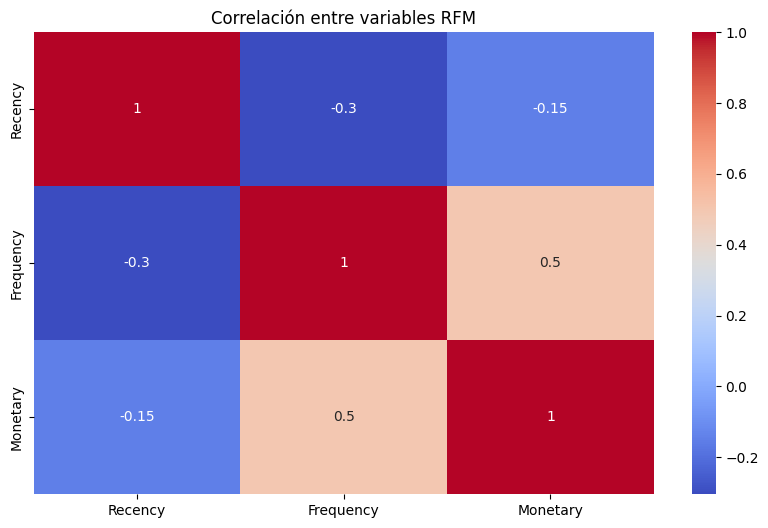

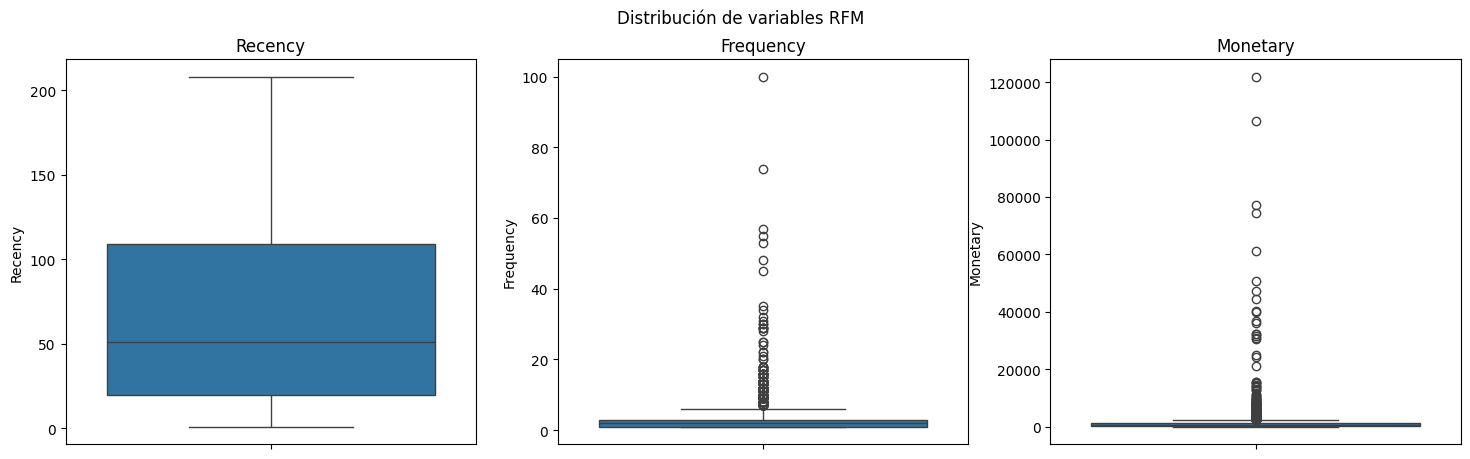

In [6]:
# Heatmap de segmentos por R, F y M
plt.figure(figsize=(10,6))
sns.heatmap(rfm[['Recency', 'Frequency', 'Monetary']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlación entre variables RFM')
plt.show()

# Boxplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.boxplot(y=rfm['Recency'], ax=axes[0])
sns.boxplot(y=rfm['Frequency'], ax=axes[1])
sns.boxplot(y=rfm['Monetary'], ax=axes[2])
axes[0].set_title('Recency')
axes[1].set_title('Frequency')
axes[2].set_title('Monetary')
plt.suptitle('Distribución de variables RFM')
plt.show()


In [7]:
# Agrupar por clúster y obtener estadísticas
cluster_summary = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
}).round(1)

display(cluster_summary)

# Interpretación rápida (puedes imprimirla también)
for cluster in cluster_summary.index:
    r = cluster_summary.loc[cluster, ('Recency', 'mean')]
    f = cluster_summary.loc[cluster, ('Frequency', 'mean')]
    m = cluster_summary.loc[cluster, ('Monetary', 'mean')]
    print(f"📦 Segmento {cluster}:")
    print(f"   🔁 Recency: {r} días")
    print(f"   🔂 Frecuencia media: {f} compras")
    print(f"   💰 Gasto medio: £{m}")
    if r < 60 and f > 5:
        print("   💎 Posible cliente VIP. ¡Vale la pena retenerlo!\n")
    elif r > 200 and f <= 2:
        print("   🧊 Cliente inactivo o perdido. Considera reactivarlo.\n")


Recency Frequency Monetary      
           mean      mean     mean count
Cluster                                 
0          17.6      11.1   4608.4   230
1         146.9       1.3    420.3   902
2          19.4      31.1  47166.6    20
3          39.5       2.4    841.7  1779

📦 Segmento 0:
   🔁 Recency: 17.6 días
   🔂 Frecuencia media: 11.1 compras
   💰 Gasto medio: £4608.4
   💎 Posible cliente VIP. ¡Vale la pena retenerlo!

📦 Segmento 1:
   🔁 Recency: 146.9 días
   🔂 Frecuencia media: 1.3 compras
   💰 Gasto medio: £420.3
📦 Segmento 2:
   🔁 Recency: 19.4 días
   🔂 Frecuencia media: 31.1 compras
   💰 Gasto medio: £47166.6
   💎 Posible cliente VIP. ¡Vale la pena retenerlo!

📦 Segmento 3:
   🔁 Recency: 39.5 días
   🔂 Frecuencia media: 2.4 compras
   💰 Gasto medio: £841.7


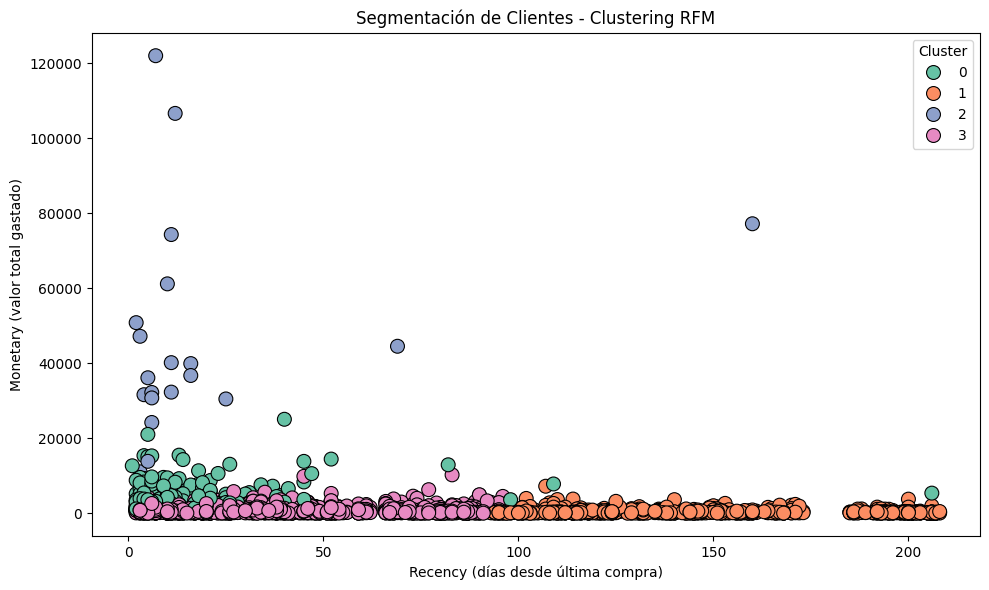

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Paleta de colores
palette = sns.color_palette("Set2", len(rfm['Cluster'].unique()))

# Crear gráfico
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=rfm,
    x='Recency',
    y='Monetary',
    hue='Cluster',
    palette=palette,
    s=100,
    edgecolor='k'
)
plt.title('Segmentación de Clientes - Clustering RFM')
plt.xlabel('Recency (días desde última compra)')
plt.ylabel('Monetary (valor total gastado)')
plt.legend(title='Cluster')
plt.tight_layout()

# Guardar imagen como PNG
plt.savefig('rfm_clusters.png', dpi=300)
plt.show()


In [9]:
pip install -U kaleido

In [10]:
import plotly.express as px

fig = px.scatter_3d(
    rfm.reset_index(),
    x='Recency',
    y='Frequency',
    z='Monetary',
    color='Cluster',
    title='Segmentación de Clientes en 3D (RFM + KMeans)',
    color_discrete_sequence=px.colors.qualitative.Set1
)
fig.show()

# Para guardar la imagen como HTML o PNG (requiere instalar kaleido)
fig.write_image("rfm_clusters_3d.png")